In [13]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

def LYSO_part(t, tau1, QsuC):            #funzione di fit per lyso, fit solo della salita
    return QsuC*(1-np.exp(-(t)/tau1))



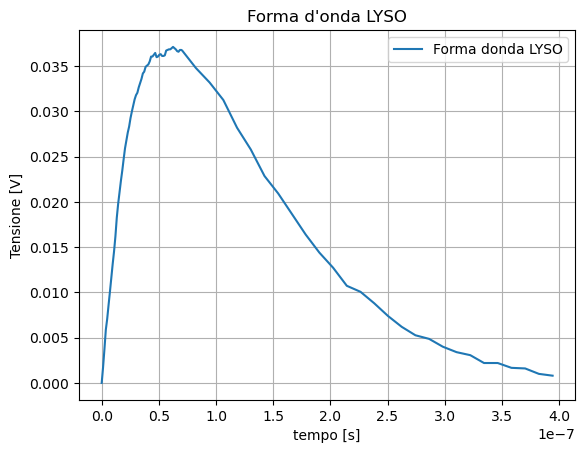

In [14]:
#FIT FORMA D'ONDA LYSO

data = pd.read_csv('LYSO-Forma.CSV', delimiter=';')
data1= pd.read_csv('LYSO-Salita.CSV', delimiter=';')
data2= pd.read_csv('LYSO-Discesa.CSV', delimiter=';')


times=np.array(data1['Time']+3.36e-08)[::3]
timed=np.array(data2['Time']+3.36e-08)[::30]
volts = np.array(data1['Voltage']-0.0007333333333333333)[::3]
voltd = np.array(data2['Voltage']-0.0007333333333333333)[::30]
time = np.concatenate((times,timed))    
volt = np.concatenate((volts,voltd))


#err sist sensibilità oscilloscopio
err_volt_s = np.array(data1['error'])[::3]
err_volt_d = np.array(data2['error'])[::30]
err_volt = np.sqrt((np.concatenate((err_volt_s,err_volt_d))/np.sqrt(6))**2)

plt.plot(time, volt, label='Forma donda LYSO')
plt.xlabel('tempo [s]')
plt.ylabel('Tensione [V]')
plt.title('Forma d\'onda LYSO') 
plt.legend()
plt.grid()
plt.show()

In [15]:
def repeat_fit(ls, left_bound, right_bound, tau1, QsuC, larghezza_minima1, dis=False, limit_Time=0.2e-7):
    '''
    ampiezza picco limite = è la ampiezza dell'intorno di tau in cui è accettabile avere il picco
    '''
    tau1_list = []
    error_tau1_list = []
    QsuC_list = []
    error_QsuC_list = []
    for delta_Time in np.arange(0, abs(right_bound-left_bound)/2+limit_Time, 0.01e-7):
        ls.mask = (time > left_bound+delta_Time) & (time < right_bound-delta_Time)
        m = Minuit(ls, tau1=tau1, QsuC=QsuC)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['tau1'] < (tau1+larghezza_minima1/2) and m.values['tau1'] > (tau1-larghezza_minima1/2):    
                tau1_list.append(m.values['tau1'])
                error_tau1_list.append(m.errors['tau1'])
                QsuC_list.append(m.values['QsuC'])
                error_QsuC_list.append(m.errors['QsuC'])
                if dis==True: display(m)
        ls.mask = None
    for delta_Time in np.arange(0, abs(right_bound-left_bound)/2+limit_Time, 0.01e-7):
        ls.mask = (time > left_bound+delta_Time) & (time < right_bound-delta_Time/2)
        m = Minuit(ls, tau1=tau1, QsuC=QsuC)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['tau1'] < (tau1+larghezza_minima1/2) and m.values['tau1'] > (tau1-larghezza_minima1/2):  
                tau1_list.append(m.values['tau1'])
                error_tau1_list.append(m.errors['tau1'])
                QsuC_list.append(m.values['QsuC'])
                error_QsuC_list.append(m.errors['QsuC'])
                if dis==True: display(m)
        ls.mask = None
    for delta_Time in np.arange(0, abs(right_bound-left_bound)/2+limit_Time, 0.01e-7):
        ls.mask = (time > left_bound+delta_Time/2) & (time < right_bound-delta_Time)
        m = Minuit(ls, tau1=tau1, QsuC=QsuC)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['tau1'] < (tau1+larghezza_minima1/2) and m.values['tau1'] > (tau1-larghezza_minima1/2):    
                    tau1_list.append(m.values['tau1'])
                    error_tau1_list.append(m.errors['tau1'])
                    QsuC_list.append(m.values['QsuC'])
                    error_QsuC_list.append(m.errors['QsuC'])
                    if dis==True: display(m)
        ls.mask = None
    return np.array(tau1_list), np.array(error_tau1_list), np.array(QsuC_list), np.array(error_QsuC_list),

tau1: [3.61166336e-08 3.67191091e-08 3.55394184e-08 3.69358241e-08
 3.94498459e-08 4.32719565e-08] +- [1.25121224e-08 1.65407471e-08 3.21870386e-08 7.40908795e-09
 9.28727857e-09 1.33678688e-08]
QsuC: [0.05937392 0.06042371 0.05928323 0.05978887 0.06305936 0.06812528] +- [0.01554096 0.02082389 0.04113244 0.00897433 0.01145988 0.01683656]
tau: 3.816887225476678e-08 +- 3.866269026073788e-09
QsuC: 0.06154590733711143 +- 0.004421026873321934


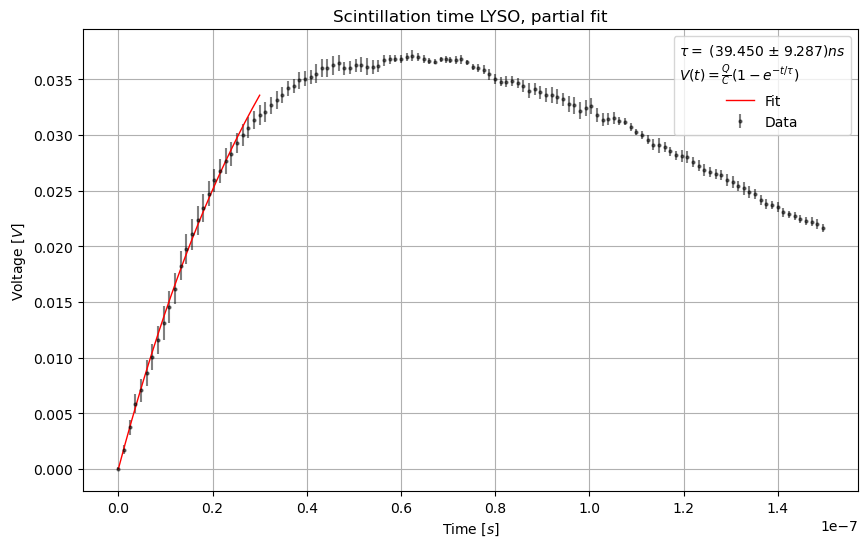

In [16]:
#fit Lyso parz

ls = LeastSquares(time, volt, err_volt, LYSO_part)

#maschere
t_low=0
t_up=0.35e-7
tau1_list, error_tau1_list, QsuC_list, err_QsuC_list,  = repeat_fit(ls, t_low, t_up,  tau1=0.040e-6, QsuC=10000, larghezza_minima1=1e-8,dis=False)

print(f"tau1: {tau1_list} +- {error_tau1_list}")
print(f"QsuC: {QsuC_list} +- {err_QsuC_list}")

def weighted_mean(values, errors):
    mean = np.sum(values/(errors**2))/np.sum(1/(errors**2))
    error_mean = abs(np.max(values) - np.min(values))/2 # errore sistematico dovuto alla scelta del range di interpolazione.
    # non è errore statistico perchè non è dato dalla ripetizione della misura
    return mean, error_mean

tau1_mean, tau1_error_mean = weighted_mean(tau1_list, error_tau1_list)
QsuC_mean, QsuC_error_mean = weighted_mean(QsuC_list, err_QsuC_list)

print(f"tau: {tau1_mean} +- {tau1_error_mean}")
print(f"QsuC: {QsuC_mean} +- {QsuC_error_mean}")


# plot finale

times=np.array(data1['Time']+3.36e-08)[::3]
timed=np.array(data2['Time']+3.36e-08)[:200:3]
volts = np.array(data1['Voltage']-0.0007333333333333333)[::3]
voltd = np.array(data2['Voltage']-0.0007333333333333333)[:200:3]
time = np.concatenate((times,timed))    
volt = np.concatenate((volts,voltd))


#err sist sensibilità oscilloscopio
err_volt_s = np.array(data1['error'])[::3]
err_volt_d = np.array(data2['error'])[:200:3]
err_volt = np.sqrt((np.concatenate((err_volt_s,err_volt_d))/np.sqrt(6))**2+(0.00012)**2)

x_axis = np.linspace(0,0.3e-7, 1000)
y = LYSO_part(x_axis, tau1_list[4], QsuC_list[4])
plt.subplots(figsize=(10, 6))
plt.errorbar(time, volt, err_volt, fmt='o', label='Data', markersize=2, alpha=0.5, color='black')
plt.plot(x_axis, y, color='red', label='Fit', linewidth=1)
fit_info = []
fit_info.append(f'$\\tau = $ ({ tau1_list[4]*1000000000:.3f} $\\pm$ { error_tau1_list[4]*1000000000:.3f})' + '$ns$')
fit_info.append('$V(t) = \\frac{Q}{C}(1-e^{-t/\\tau})$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.title('Scintillation time LYSO, partial fit')
plt.grid(True)
plt.xlabel('Time $[s]$')
plt.ylabel('Voltage $[V]$')
plt.show()